### Spatial Analysis of 2019 311 Data

For Group Assignment #4, I'm going to do a spatial correlation analysis of 311 pothole data from 2019. I'm going to use the joined dataset from the midterm that assigned the 311 point number and median closure time to each census block in Oakland.

This analysis should produce: 
 - A spatial lag value for each census block, based on the characteristics of neighboring census blocks for both number of 311 complaints and the median time to close those complaints. 
 - A map of the spatial lage value for both the 311 count and time to close values. 
 - Calculation of a moran value for both the 311 count and time to close values.
 - Identification of "donut" and "diamond" census blocks for median request closure time. 
 - A moran's plot that indicates a P-value for median request closure time.  
 - A scatterplot and map with HH, HL, LH, and LL values for median request closure time. 
 
 Hopefully this analysis will allow us to see trends that weren't visible in the original crowded maps of just 311 request counts and closure times. 

**Data and Library Import**

In [2]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px


In [44]:
# Importing the data from the "Midterm-311Data-2019" notebook that contains census blocks and 311 request count.
blockcount2019gdf = gpd.read_file('blockcountgdf.geojson')

**Data Clean-Up**

In [4]:
# Let's just remind ourselves what this data looks like. 
blockcount2019gdf.head(2)

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0        06   G5040         Block 2002  +37.8010533      2002        0   
1        06   G5040         Block 3007  +37.7949838      3007        0   

  funcstat10 aland10          geoid10 tractce10    intptlon10 ur10 countyfp10  \
0          S    2140  060014053012002    405301  -122.2543675             001   
1          S   11456  060014054013007    405401  -122.2521420             001   

   counts                                           geometry  
0       4  MULTIPOLYGON (((-122.25395 37.80253, -122.2541...  
1       1  MULTIPOLYGON (((-122.25211 37.79567, -122.2519...

In [5]:
# Re-project to mercator for basemaps
blockcount2019gdf = blockcount2019gdf.to_crs(epsg=3857)

**Spatial Weighting**

In [6]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(blockcount2019gdf,k=4)

# Row-standardization
wq.transform = 'r'

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [7]:
# Add a new column for our spatial weight. 
blockcount2019gdf['counts_lag'] = lps.weights.lag_spatial(wq, blockcount2019gdf['counts'])

In [45]:
# Let's take a look at a sample of the difference between counts and lag
blockcount2019gdf.sample(10)[['counts','counts_lag']]

KeyError: "['counts_lag'] not in index"

In [9]:
# Let's create a new column to show that difference 
blockcount2019gdf['counts_lag_diff'] = blockcount2019gdf['counts'] - blockcount2019gdf['counts_lag']

In [10]:
# Let's see the biggest differences
blockcount2019gdf.sort_values(by='counts_lag_diff')

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
222         06   G5040         Block 3001  +37.7581721      3001        0   
1748        06   G5040         Block 2011  +37.8342691      2011        0   
948         06   G5040         Block 3018  +37.8168420      3018        0   
2029        06   G5040         Block 3002  +37.8461059      3002        0   
81          06   G5040         Block 3002  +37.7574406      3002        0   
...        ...     ...    ...         ...          ...       ...      ...   
2223        06   G5040         Block 1003  +37.8484530      1003        0   
1404        06   G5040         Block 3003  +37.7564771      3003        0   
398         06   G5040         Block 1015  +37.8472540      1015    25272   
1414        06   G5040         Block 2007  +37.8332164      2007        0   
1562        06   G5040         Block 1000  +37.8260833      1000        0   

     funcstat10  aland10          geoid10 tractce10    intptlon10 ur10  \
222           S    16632  060014085003001    408500  -122.1774072        
1748          S    13456  060014044002011    404400  -122.2131395        
948           S    62320  060014261003018    426100  -122.2127128        
2029          S    24391  060014044003002    404400  -122.2136922        
81            S    16744  060014085003002    408500  -122.1768565        
...         ...      ...              ...       ...           ...  ...   
2223          S  1158634  060014044001003    404400  -122.2186775        
1404          S    22610  060014085003003    408500  -122.1788697        
398           S   296701  060014043001015    404300  -122.2292738        
1414          S   176161  060014045022007    404502  -122.2114417        
1562          S    55836  060014041021000    404102  -122.2484905        

     countyfp10  counts                                           geometry  \
222         001       1  MULTIPOLYGON (((-13600659.831 4545429.556, -13...   
1748        001       1  MULTIPOLYGON (((-13604782.771 4555920.581, -13...   
948         001       2  MULTIPOLYGON (((-13604790.340 4553184.738, -13...   
2029        001       1  MULTIPOLYGON (((-13604704.402 4557473.086, -13...   
81          001       1  MULTIPOLYGON (((-13600601.833 4545325.924, -13...   
...         ...     ...                                                ...   
2223        001      21  MULTIPOLYGON (((-13605658.187 4557613.632, -13...   
1404        001      23  MULTIPOLYGON (((-13600791.967 4545210.466, -13...   
398         001      23  MULTIPOLYGON (((-13607050.460 4557822.269, -13...   
1414        001      29  MULTIPOLYGON (((-13604286.397 4556119.177, -13...   
1562        001      28  MULTIPOLYGON (((-13608735.726 4555255.192, -13...   

      counts_lag  counts_lag_diff  
222        10.75            -9.75  
1748       10.00            -9.00  
948        10.25            -8.25  
2029        9.25            -8.25  
81          9.25            -8.25  
...          ...              ...  
2223        2.00            19.00  
1404        3.25            19.75  
398         1.25            21.75  
1414        4.75            24.25  
1562        1.25            26.75  

[2248 rows x 18 columns]

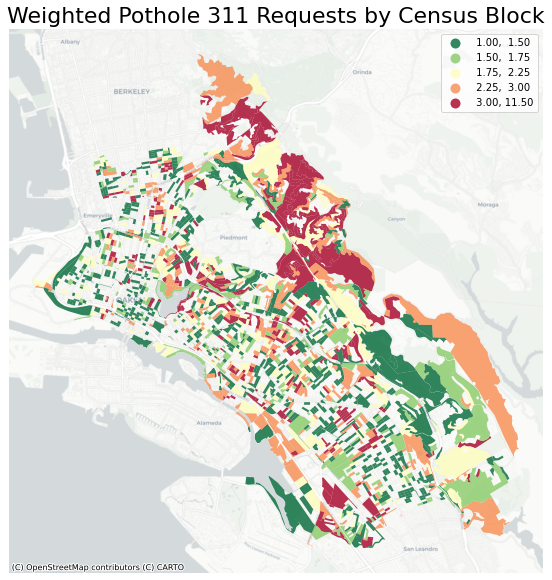

In [11]:
# Map of the 311 counts spatial weighting 
fig, ax = plt.subplots(figsize=(10, 10))

# spatial lag choropleth
blockcount2019gdf.plot(ax=ax,
         figsize=(10,10),
         column='counts_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Weighted Pothole 311 Requests by Census Block',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
# Let's see how this map compares to just a map of 311 counts, without spatial weighting. 
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
blockcount2019gdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='counts', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=4, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("311 Pothole Requests")

# spatial lag map on the right
blockcount2019gdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='counts_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=4, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("311 Pothole Requests - Spatial Lag")

plt.show()

NameError: name 'plt' is not defined

Well I'm not sure that helped all that much, the requests seem pretty dispersed even with the weighting. Maybe the hills stand out a little less with the weighting.

Let's move onto median closure time, which might benefit more from this analysis. 

In [46]:
# Import the file with the median closure time for each census block. 
closetime2019gdf = gpd.read_file('closetimegdf_web_mercator.geojson')

In [14]:
# Let's see what that looks like.
closetime2019gdf.head(2)

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0        06   G5040         Block 2002  +37.8010533      2002        0   
1        06   G5040         Block 3007  +37.7949838      3007        0   

  funcstat10 aland10          geoid10 tractce10    intptlon10 ur10 countyfp10  \
0          S    2140  060014053012002    405301  -122.2543675             001   
1          S   11456  060014054013007    405401  -122.2521420             001   

   closure_median                                           geometry  
0            46.5  MULTIPOLYGON (((-13609247.907 4551567.501, -13...  
1             7.0  MULTIPOLYGON (((-13609042.745 4550600.632, -13...

In [15]:
# Just relaized I could merge these two datasets since they include the same rows
# So I'm going to do that by merging on the census block ID
newdf = closetime2019gdf[['geoid10','closure_median']]

In [16]:
newdf.head(2)

geoid10  closure_median
0  060014053012002            46.5
1  060014054013007             7.0

In [17]:
CountTime2019gdf = blockcount2019gdf.merge(newdf,on='geoid10')

In [18]:
CountTime2019gdf.head(2)

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0        06   G5040         Block 2002  +37.8010533      2002        0   
1        06   G5040         Block 3007  +37.7949838      3007        0   

  funcstat10 aland10          geoid10 tractce10    intptlon10 ur10 countyfp10  \
0          S    2140  060014053012002    405301  -122.2543675             001   
1          S   11456  060014054013007    405401  -122.2521420             001   

   counts                                           geometry  counts_lag  \
0       4  MULTIPOLYGON (((-13609247.907 4551567.501, -13...        2.75   
1       1  MULTIPOLYGON (((-13609042.745 4550600.632, -13...        2.50   

   counts_lag_diff  closure_median  
0             1.25            46.5  
1            -1.50             7.0

Hey look at that, we have our count of requests and median closure time in the same dataset. Maybe later I can move this info into one that also includes census data and go really crazy.

In [19]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(CountTime2019gdf,k=8)

# Row-standardization
wq.transform = 'r'

In [20]:
# Create a new column for our weighitng. 
CountTime2019gdf['closure_lag'] = lps.weights.lag_spatial(wq, CountTime2019gdf['closure_median'])

In [21]:
# Let's look at a sample
CountTime2019gdf.sample(10)[['closure_median','closure_lag']]

closure_median  closure_lag
228            196.5      55.0625
1134            13.0      73.1875
1353            32.5     224.5625
1020           122.0     101.7500
138              7.5      58.6250
441            431.0     266.8750
587              2.0     154.1875
1346             5.5      24.0625
1347             5.0      64.1875
1078            48.0     141.5000

In [22]:
# Create a lag difference column
CountTime2019gdf['closure_lag_diff'] = CountTime2019gdf['closure_median'] - CountTime2019gdf['closure_lag']

In [23]:
# Let's see the biggest differences 
CountTime2019gdf.sort_values(by='closure_lag_diff')

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
1608        06   G5040         Block 4023  +37.8252011      4023        0   
1443        06   G5040         Block 4029  +37.8246841      4029        0   
188         06   G5040         Block 4024  +37.8257121      4024        0   
723         06   G5040         Block 2016  +37.7781433      2016        0   
388         06   G5040         Block 1001  +37.7979886      1001        0   
...        ...     ...    ...         ...          ...       ...      ...   
377         06   G5040         Block 1018  +37.7985811      1018        0   
955         06   G5040         Block 2003  +37.8105865      2003        0   
449         06   G5040         Block 2040  +37.7305051      2040        0   
922         06   G5040         Block 4002  +37.7749007      4002        0   
1428        06   G5040         Block 1012  +37.7414796      1012        0   

     funcstat10  aland10          geoid10  ...    intptlon10 ur10 countyfp10  \
1608          S     5212  060014045024023  ...  -122.2099019             001   
1443          S      600  060014045024029  ...  -122.2092995             001   
188           S      989  060014045024024  ...  -122.2101421             001   
723           S  1301785  060014081002016  ...  -122.1603712             001   
388           S    15871  060014066021001  ...  -122.2106886             001   
...         ...      ...              ...  ...           ...  ...        ...   
377           S     9561  060014057001018  ...  -122.2255503             001   
955           S    22124  060014051002003  ...  -122.2306102             001   
449           S     3674  060014090002040  ...  -122.2021150             001   
922           S    28830  060014076004002  ...  -122.2039937             001   
1428          S    16542  060014104001012  ...  -122.1608048             001   

     counts                                           geometry counts_lag  \
1608      4  MULTIPOLYGON (((-13604263.688 4554614.226, -13...       2.25   
1443      2  MULTIPOLYGON (((-13604253.001 4554641.848, -13...       3.00   
188       1  MULTIPOLYGON (((-13604422.207 4554903.980, -13...       2.25   
723       3  MULTIPOLYGON (((-13598558.564 4548682.375, -13...       1.25   
388       4  MULTIPOLYGON (((-13604385.249 4550787.997, -13...       1.75   
...     ...                                                ...        ...   
377       2  MULTIPOLYGON (((-13606068.288 4551058.485, -13...       4.00   
955       2  MULTIPOLYGON (((-13606787.078 4552609.419, -13...       2.00   
449       1  MULTIPOLYGON (((-13603641.078 4541547.725, -13...       2.50   
922       4  MULTIPOLYGON (((-13603571.615 4547625.076, -13...       2.50   
1428      1  MULTIPOLYGON (((-13599022.989 4542976.319, -13...       1.50   

      counts_lag_diff  closure_median  closure_lag  closure_lag_diff  
1608             1.75             5.0     480.0625         -475.0625  
1443            -1.00            12.0     479.1875         -467.1875  
188             -1.25            29.0     477.0625         -448.0625  
723              1.75             1.0     411.7500         -410.7500  
388              2.25            14.0     419.9375         -405.9375  
...               ...             ...          ...               ...  
377             -2.00           833.0      83.0625          749.9375  
955              0.00           869.0     109.6250          759.3750  
449             -1.50           873.0      96.2500          776.7500  
922              1.50           836.5      52.1875          784.3125  
1428            -0.50           860.0      21.9375          838.0625  

[1774 rows x 21 columns]

We've got some huge differences here so let's do a diamond and a donut value for this dataset. 

In [24]:
gdf_donut = CountTime2019gdf.sort_values(by='closure_lag_diff').head(1)
gdf_donut

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
1608        06   G5040         Block 4023  +37.8252011      4023        0   

     funcstat10 aland10          geoid10  ...    intptlon10 ur10 countyfp10  \
1608          S    5212  060014045024023  ...  -122.2099019             001   

     counts                                           geometry counts_lag  \
1608      4  MULTIPOLYGON (((-13604263.688 4554614.226, -13...       2.25   

      counts_lag_diff  closure_median  closure_lag  closure_lag_diff  
1608             1.75             5.0     480.0625         -475.0625  

[1 rows x 21 columns]

In [25]:
gdf_diamond = CountTime2019gdf.sort_values(by='closure_lag_diff').tail(1)
gdf_diamond

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
1428        06   G5040         Block 1012  +37.7414796      1012        0   

     funcstat10 aland10          geoid10  ...    intptlon10 ur10 countyfp10  \
1428          S   16542  060014104001012  ...  -122.1608048             001   

     counts                                           geometry counts_lag  \
1428      1  MULTIPOLYGON (((-13599022.989 4542976.319, -13...        1.5   

      counts_lag_diff  closure_median  closure_lag  closure_lag_diff  
1428             -0.5           860.0      21.9375          838.0625  

[1 rows x 21 columns]

In [26]:
token = 'pk.eyJ1Ijoibmlja21vb3JlMTQ0IiwiYSI6ImNrdzhueTNvbzIybmIzMnBkN2pueW9kYXoifQ._aLF0L_ibbqWIIfKXhtAKQ'
px.set_mapbox_access_token(token)

In [27]:
# subset donut, project to WGS84, and get its centroid
gdf_donut = gdf_donut.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = gdf_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

In [28]:
# subset diamond, project to WGS84, and get its centroid
gdf_diamond = gdf_diamond.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = gdf_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

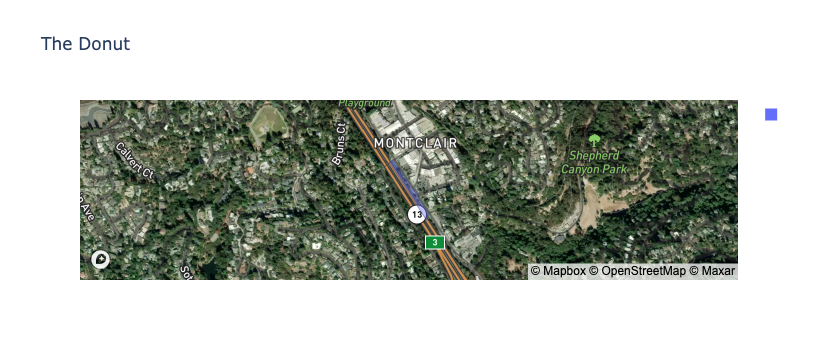

In [29]:
px.choropleth_mapbox(gdf_donut, 
                     geojson=gdf_donut.geometry, 
                     locations=gdf_donut.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['counts','closure_median','closure_lag'],
                     opacity=0.4,
                     title='The Donut')

So our donut, an area with a quick closure time for requests surrounded by areas with much longer closure times, is in the upscale area of Montclair but it also appears to cover exclusively a portion of highway 13. This census block only had 4 requests in 2019, so it's not a huge sample, but those 4 requests had a median closure time of just 5 days. That is blazing fast compared to the 2019 average of 34 days. 

Given that these potholes, if there are even multiple potholes represented by the 4 requests, were on what is likely a highly trafficked road and adjacent to a wealthy neighborhood, these potholes probably had a lot of visibility. That might explain the city's fast response. Or perhaps they just closed the complaints because they were referred to CalTrans. 

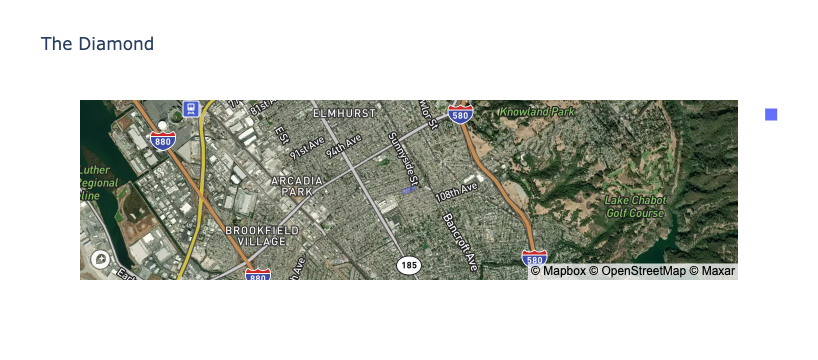

In [30]:
px.choropleth_mapbox(gdf_diamond, 
                     geojson=gdf_diamond.geometry, 
                     locations=gdf_diamond.index, 
                     mapbox_style="satellite-streets",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['counts','closure_median','closure_lag'],
                     opacity=0.4,
                     title='The Diamond')

Another very small geographic area for our diamond. This one is covering city streets though. 

Only one service request in the area made in 2019, which was addressed 819 days later, so that's sometime just this year. 

*Also worth noting that this isn't really a perfect analysis, because a third of the requests from 2019 are still open.*

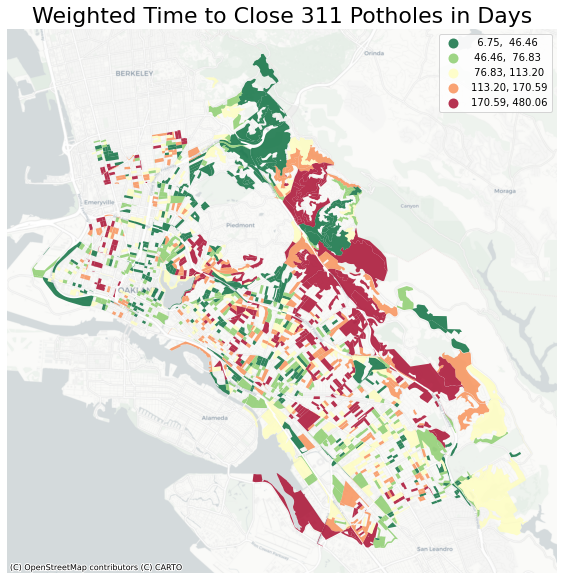

In [47]:
# Let's get on with the map for the closure time spatial weight
fig, ax = plt.subplots(figsize=(10, 10))

# spatial lag choropleth
CountTime2019gdf.plot(ax=ax,
         figsize=(10,10),
         column='closure_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Weighted Time to Close 311 Potholes in Days',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

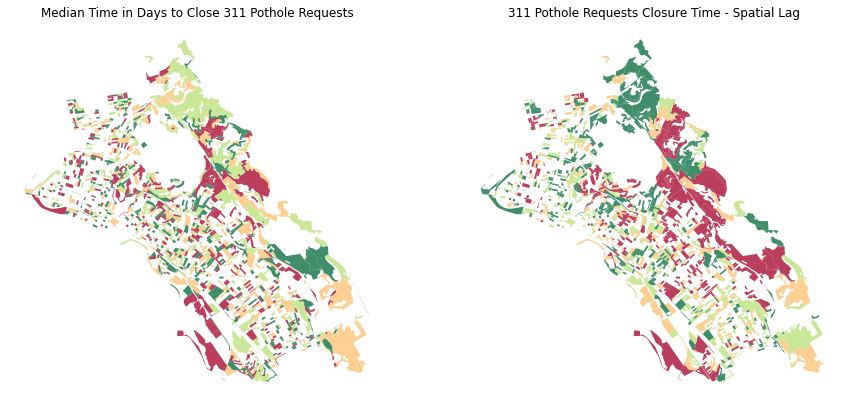

In [32]:
# Let's do side by side for this one too 
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
CountTime2019gdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='closure_median', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=4, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Median Time in Days to Close 311 Pothole Requests")

# spatial lag map on the right
CountTime2019gdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='closure_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=4, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("311 Pothole Requests Closure Time - Spatial Lag")

plt.show()

On median closure time of pothole requests, we might actually be revealing some trends with the spatial weighting. To me, I see a general clustering in the center of Oakland, with particularly fewer concentrations of longer response times in the North.

Interestingly, in the spatial map, the census blocks of downtown and uptown Oakland are almost entirely in the bottom two quantiles. It might make intuitive sense that the potholes in downtown recieve a.lot of visibility or affect more users, so the potholes there are getting addressed faster. 

**Moran numbers**

In [33]:
# Time to close
y = CountTime2019gdf.closure_median
moran = Moran(y, wq)
moran.I

0.06540953482832593

Ok, well it's close to zero so I don't think there's much. 

In [34]:
# Count of 311 requests
y = CountTime2019gdf.counts
moran2 = Moran(y, wq)
moran2.I

0.07274493162596325

Interestingly, there might be more of a correlation with the number of 311 requests, if only by a little. 

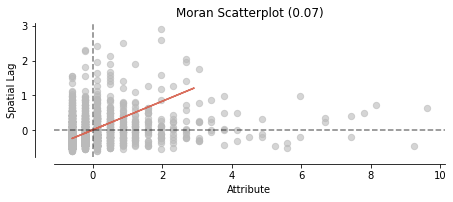

In [35]:
# 311 count plot
fig, ax = moran_scatterplot(moran2, aspect_equal=True)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.07', ylabel='Density'>)

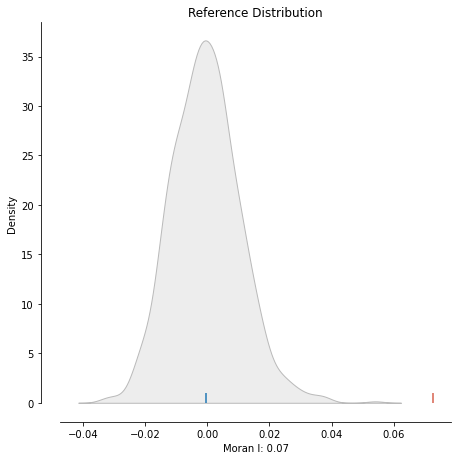

In [36]:
# 311 count graph
plot_moran_simulation(moran2,aspect_equal=False)

In [37]:
# 311 count p value
moran2.p_sim

0.001

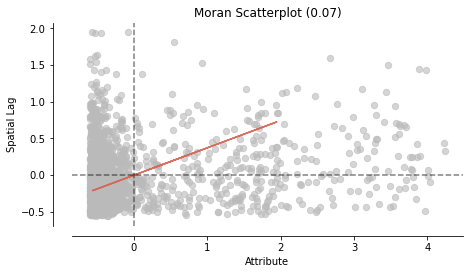

In [38]:
# Time to closure plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.07', ylabel='Density'>)

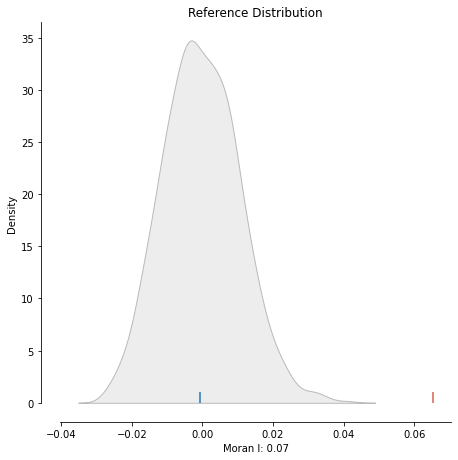

In [39]:
# Time to closure graph  
plot_moran_simulation(moran,aspect_equal=False)

In [40]:
# Time to Close p value
moran.p_sim

0.001

Ok, well it's not random, wooo! 

In [41]:
# Time to close LISA
lisa = esda.moran.Moran_Local(y, wq)

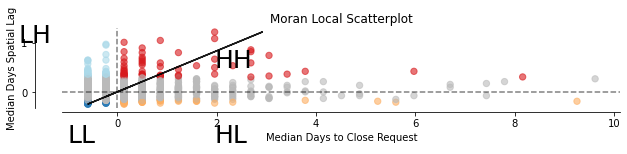

In [42]:
# So I think I'm plotting the time to close median vs the time to close median lag
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Median Days to Close Request")
ax.set_ylabel("Median Days Spatial Lag")

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

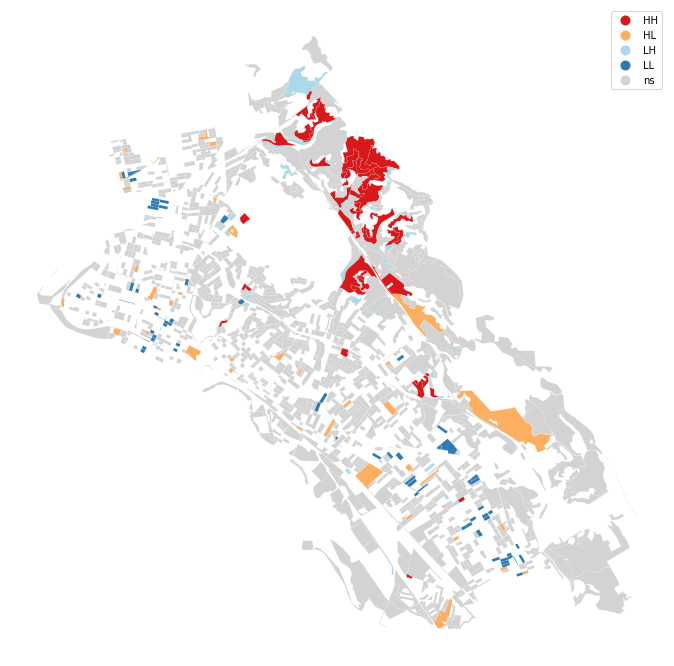

In [43]:
# Let's map it! 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, CountTime2019gdf, p=0.05, ax=ax)
plt.show()

I hope I did this last one right, I'm not entirely sure how the moran.Moran_local code new which columns I was referencing but heopfully it worked out. 

If so, it looks like me earlier analysis might have been right, with downtown having a good number of the LL blocks indicating a low median close time in both the raw and weighted values. 

This analysis also shows the Northern hills being high in both the raw median closure time and when weighted. 

Semms like the weighting had a big impact in the flatlands of central Oakland (indicated by the orange colored blocks). 

**Future Work**

I think I'd like to continue to use spatial analysis in the following ways to identify trends in our dataset: 

- A spatial correlation between block racial demographics and time to close 
- A point pattern analysis of the unjoined 311 pothole points from 2019. 

In [1]:
CountTime2019gdf.to_file("CountClose2019.geojson", driver='GeoJSON')

NameError: name 'CountTime2019gdf' is not defined